In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Input
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [2]:
file_path = r"F:\Xai_traderx\data\processed\reliance_processed.csv"
df = pd.read_csv(file_path)

In [3]:
df.head()

,Date,Close,High,Low,Open,Volume,Close_Return_1D,Close_Return_3D,Return,High_Low_Spread,...,bb_upper,bb_lower,bb_width,Bollinger_%B,bear_score,bull_strength,bear_strength,Momentum,Volatility,next_close
0,2020-07-15,845.291199,907.083664,824.204808,888.357962,139669773,-0.038080,-0.018131,-0.038080,0.098048,...,885.494315,748.906497,0.167141,0.705661,0.3,0.0,0.0,21.086426,32.846620,845.016235
1,2020-07-16,845.016235,856.751295,830.828700,846.666456,60961724,-0.000325,-0.047338,-0.000325,0.030677,...,885.040723,757.955108,0.154700,0.685059,0.0,0.0,0.0,8.778442,31.822700,876.324951
2,2020-07-17,876.324951,880.129674,842.540773,845.749610,49726765,0.037051,-0.002765,0.037051,0.042894,...,892.604734,757.372542,0.163920,0.879616,0.0,0.0,0.0,15.425171,31.281957,880.083801
3,2020-07-20,880.083801,885.630471,870.801218,879.121193,36592938,0.004289,0.041160,0.004289,0.016850,...,899.803924,758.138062,0.170894,0.860798,0.0,0.0,0.0,-6.921875,28.300401,903.760254
4,2020-07-21,903.760254,906.258562,887.693335,888.839335,42173371,0.026902,0.069518,0.026902,0.020542,...,910.328241,759.103565,0.181169,0.956568,0.0,0.0,0.0,25.005798,28.440126,918.635376


In [4]:
## We using same approch that done for Axis bank

In [5]:
selected_features = [
    # Price Action
    'Close', 'High', 'Low', 
    
    # Trends
    'EMA_12', 'EMA_50', 
    
    # Volatility/Volume
    'OBV', 'ATR',
    # Momentum
    'Close_Return_1D','MACD_Hist'
]

In [6]:
df_selected = df[selected_features]

In [7]:
# Separate features and target
features = df_selected
target = df[['next_close']]

In [8]:
# Scale features
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(features)

# Scale target
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(target)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, shuffle=False, test_size=0.2)

In [9]:
lookback = 4
def create_sequence(X, y, lookback):
    Xs, ys = [], []
    for i in range(len(X) - lookback):
        Xs.append(X[i:(i + lookback)])
        ys.append(y[i + lookback])
    return np.array(Xs), np.array(ys)


X_train_seq, y_train_seq = create_sequence(X_train, y_train, lookback)
X_test_seq, y_test_seq = create_sequence(X_test, y_test, lookback)

In [10]:
# Print shapes of training and testing sequences
print("Shape of X_train_seq:", X_train_seq.shape)
print("Shape of y_train_seq:", y_train_seq.shape)
print("Shape of X_test_seq:", X_test_seq.shape)
print("Shape of y_test_seq:", y_test_seq.shape)

Shape of X_train_seq: (945, 4, 9)
Shape of y_train_seq: (945, 1)
Shape of X_test_seq: (234, 4, 9)
Shape of y_test_seq: (234, 1)


In [11]:
model = Sequential([
    Input(shape=(lookback, X_train_seq.shape[2])),
    GRU(100, return_sequences=True),
    Dropout(0.2),
    GRU(100, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])
print("Model Builded")

# Compile
optimizer = Nadam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss=Huber(), metrics=['mae'])

Model Builded


In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 4, 100)         │        33,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 100)            │        60,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,001 (367.19 KB)

 Trainable params: 94,001 (367.19 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
callbacks = [
    EarlyStopping(monitor='val_mae', patience=50, restore_best_weights=True),
    ModelCheckpoint('reliancegru.keras', save_best_only=True),
    ReduceLROnPlateau(monitor='val_mae', factor=0.5, patience=25, min_lr=1e-6)
]

# training
history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=500,
    batch_size=16,
    callbacks=callbacks,
    shuffle=False,  
    verbose=1
)
print('training Completed...')

Epoch 1/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0167 - mae: 0.1555 - val_loss: 0.0054 - val_mae: 0.0904 - learning_rate: 1.0000e-04
Epoch 2/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0141 - mae: 0.1393 - val_loss: 0.0024 - val_mae: 0.0587 - learning_rate: 1.0000e-04
Epoch 3/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0052 - mae: 0.0842 - val_loss: 0.0021 - val_mae: 0.0523 - learning_rate: 1.0000e-04
Epoch 4/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029 - mae: 0.0612 - val_loss: 0.0022 - val_mae: 0.0543 - learning_rate: 1.0000e-04
Epoch 5/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0028 - mae: 0.0578 - val_loss: 0.0017 - val_mae: 0.0465 - learning_rate: 1.0000e-04
Epoch 6/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0025 - mae: 0.0558 - val_loss: 0.0023 - val_mae: 0.0551 - learning_rate: 1.0000e-04
Epoch 7/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0025 - mae: 0.0562 - val_loss: 0.0015 - val_mae: 0.0425 - learning_r

In [14]:
test_loss, test_mae = model.evaluate(X_test_seq, y_test_seq)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.3717e-04 - mae: 0.0301
Test Loss: 0.0007646764861419797
Test MAE: 0.02932986430823803


In [15]:
y_pred_scaled = model.predict(X_test_seq)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


In [16]:
y_pred_scaled = y_pred_scaled.reshape(-1, 1)
y_test_seq = y_test_seq.reshape(-1, 1)

# Inverse transform
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test_seq)

In [17]:
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)
percentage_error = (mae / np.mean(y_true)) * 100

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2 Score: {r2:.4f}")
print(f"Percentage Error: {percentage_error:.2f}%")

MAE: 22.1895
RMSE: 29.5863
R2 Score: 0.9386
Percentage Error: 1.63%


In [19]:
result_df = pd.DataFrame({
    'Actual': y_true.flatten(),
    'Predicted': y_pred.flatten()
})

result_df

,Actual,Predicted
0,1486.050049,1433.169312
1,1480.250000,1454.738037
2,1466.250000,1476.509888
3,1456.199951,1473.916992
4,1440.775024,1465.283203
...,...,...
229,1300.400024,1293.034180
230,1368.800049,1296.359253
231,1399.699951,1298.008545
232,1405.000000,1359.928223


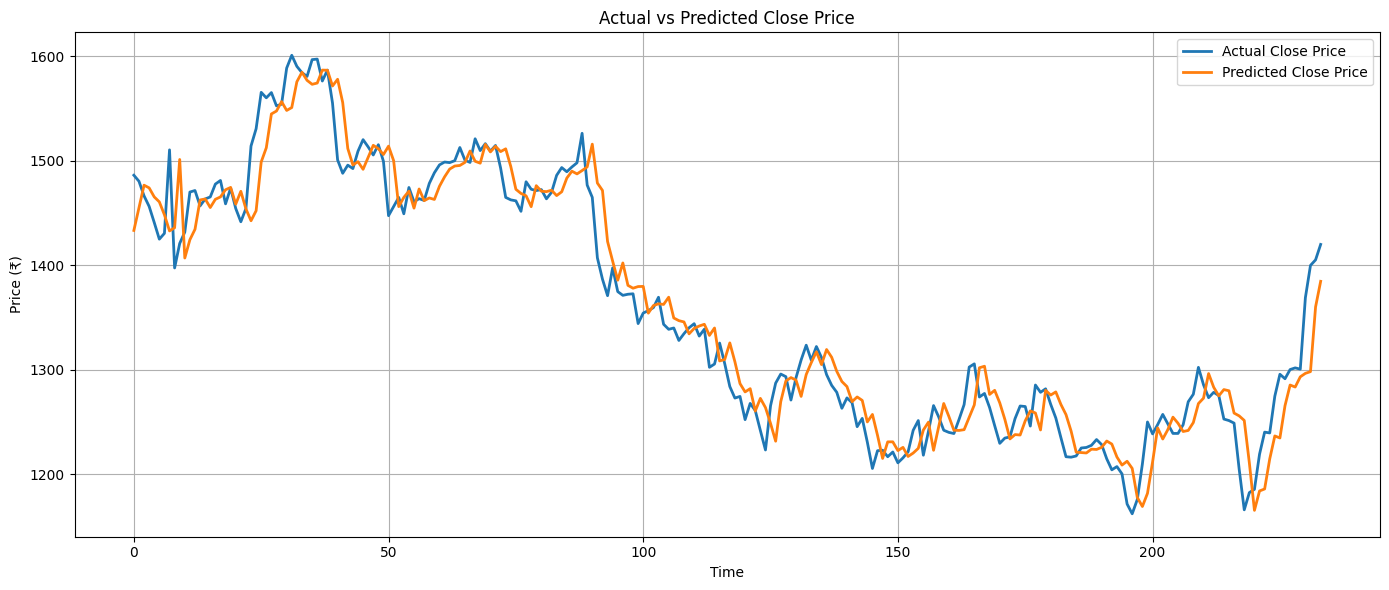

In [20]:
plt.figure(figsize=(14, 6))
plt.plot(y_true, label='Actual Close Price', linewidth=2)
plt.plot(y_pred, label='Predicted Close Price', linewidth=2)
plt.title('Actual vs Predicted Close Price')
plt.xlabel('Time')
plt.ylabel('Price (₹)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

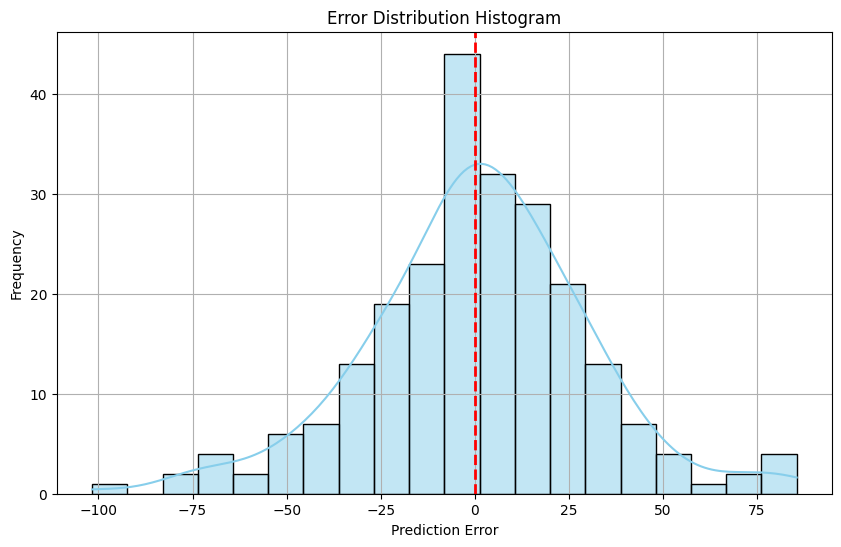

In [21]:
result_df['Error'] = result_df['Predicted'] - result_df['Actual']
plt.figure(figsize=(10, 6))
sns.histplot(result_df['Error'], bins=20, kde=True, color='skyblue')
plt.axvline(0, color='red', linestyle='--', linewidth=2)
plt.title('Error Distribution Histogram')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
6625/6625 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
6625/6625 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
6625/6625 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
6625/6625 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
6625/6625 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
6625/6625 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
6625/6625 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
6625/6625 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
6625/6625 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
6625/6625 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step


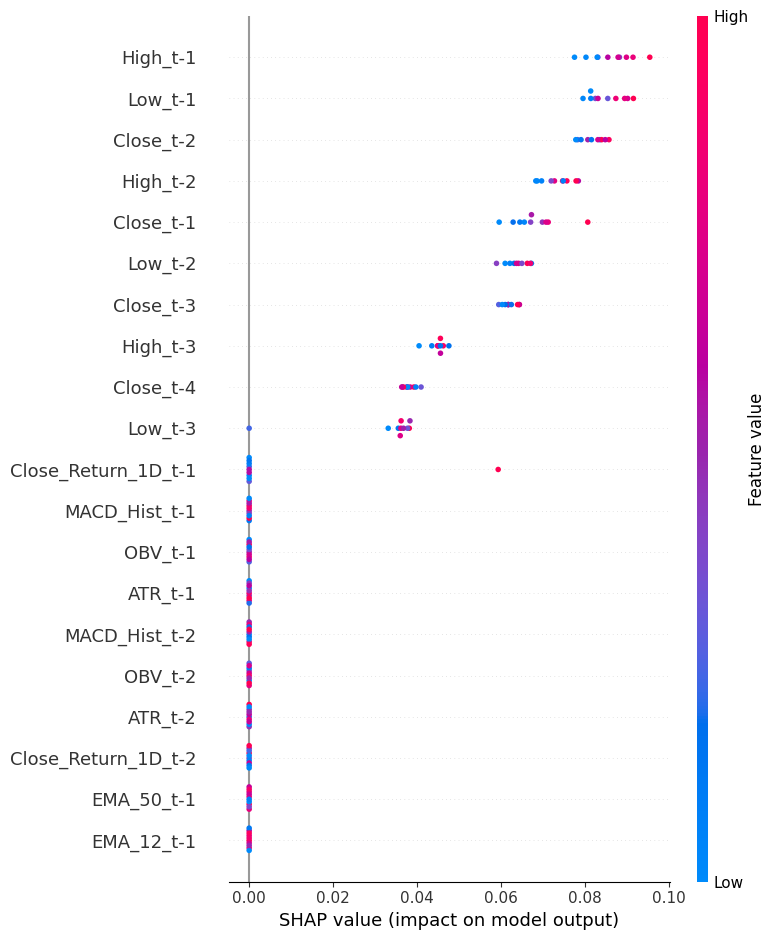

In [22]:
import shap
# 1. Prepare a sample of your training data (first 100 samples)
background = X_train_seq[:100].reshape(100, -1)  # Flatten time steps

# 2. Create a prediction function that handles GRU input shape
def predict_fn(X):
    return model.predict(X.reshape(-1, lookback, len(selected_features))).flatten()

# 3. Initialize KernelExplainer
explainer = shap.KernelExplainer(predict_fn, background)

# 4. Calculate SHAP values for test samples (first 10 samples)
test_samples = X_test_seq[:10].reshape(10, -1)
shap_values = explainer.shap_values(test_samples)

# 5. Plot results
shap.summary_plot(shap_values, 
                 test_samples,
                 feature_names=[f"{feat}_t-{i}" 
                              for i in range(lookback, 0, -1) 
                              for feat in selected_features])